In [1]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA-Secondary-Structure-Prediction/notebook/EKH-25")

## Imports

In [2]:
from collections import defaultdict
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil
import pickle

___

## Global Variables

In [3]:
predicted_struct = {}

## Pairing Charecters

In [4]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [5]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [6]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

## Verify Sequences

In [7]:
def is_valid_str(input_string, valid_characters = ['A','C', 'G', 'U']):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

## Create Tree

In [8]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=True):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !./phyml -i tmp/sequences.phylip -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  
  Phylo.draw(output_tree)
  
  return output_tree

## Get Mutation Probablities

In [9]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"], gappy=False):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
            
    if gappy:      
        if order_array == ["A", "C", "G", "U"]:
            for i_index, i_value in enumerate(order_array):
                for _, j_value in enumerate(["-"]):
                    probability_rate_values[(i_value, j_value)] = 1
        else:
            for i_index, i_value in enumerate(order_array):
                for j_index, j_value in enumerate(['A-', '-A', 'C-', '-C', 'G-', '-G', 'U-', '-U', '--']):
                    if j_value == "--":
                        probability_rate_values[(i_value, j_value)] = 1
                    else:
                        __probability = 0
                        for nocleotid in ["A", "C", "G", "U"]:
                            __j_value = j_value.replace('-', nocleotid)
                            __probability += probability_rate_values[(i_value, __j_value)]
                                
                        probability_rate_values[(i_value, j_value)] = __probability
    
        
    return probability_rate_values

# Check Column

In [10]:
def column_needed(tuple1, tuple2):
    return len(tuple1) == len(tuple2) and all(t1 == t2 for t1, t2 in zip(tuple1, tuple2))

In [11]:
def get_columns(input_sequences, leaf_order):
    columns = defaultdict(list)
    
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column].append(i)
    return columns

In [12]:
def check_column(input_sequences, column, leaf_order):
    __leaf_order = leaf_order[-len(column):]
    columns = get_columns(input_sequences, __leaf_order)
    
    if len(column[0]) == 1:
        for _column, _places in columns.items():
            if column_needed(column, _column):
                return True
    else:
        for _column1, _places1 in columns.items():
            left_column = tuple(
                    pair[0] for pair in column if pair
            )
            if column_needed(left_column, _column1):
                for _column2, _places2 in columns.items():
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if _places2 != [] and column_needed(right_column, _column2):
                        if _places1[0] < _places2[-1]:
                            return True
    
    return False       

## Post Order Traversal

In [13]:
def post_order_traversal(tree, current_node, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values, True)
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                for left_column in perv_columns_probability:
                    for child_value in tips_possible_values:
                        if check_column(input_sequences, left_column + (child_value ,), leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + (child_value ,)][root] = (
                                    mutation_probablities[(root, child_value)] * 
                                    perv_columns_probability[left_column][root]
                                )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                # for mutation in mutation_probablities:
                for child_value in tips_possible_values:
                    if check_column(input_sequences, (child_value ,), leaf_order):
                        for parent_value in interior_possible_values:
                            current_columns_probability[(child_value ,)][parent_value] = mutation_probablities[(parent_value, child_value)]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for right_column in inner_columns_probability:
                        if check_column(input_sequences, left_column + right_column, leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + right_column][root] = sum(
                                    (
                                        mutation_probablities[(root, inner_root)] * 
                                        inner_columns_probability[right_column][inner_root] * 
                                        perv_columns_probability[left_column][root]
                                    ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in interior_possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

## Get Columns Probability

In [14]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences,
):
    single_interior_possible_values = ['A', 'C', 'G', 'U']
    paired_interior_possible_values = [c1 + c2 for c1 in single_interior_possible_values for c2 in single_interior_possible_values]
    
    single_tips_possible_values = ['A', 'C', 'G', 'U', '-']
    paired_tips_possible_values = [c1 + c2 for c1 in single_tips_possible_values for c2 in single_tips_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_interior_possible_values,
        single_tips_possible_values, 
        single_rate_values,
        input_sequences,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_interior_possible_values
        )
    __single_columns_probability.clear()
    
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_interior_possible_values, 
        paired_tips_possible_values,
        paired_rate_values,
        input_sequences,
        [],
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_interior_possible_values
        )
    __paired_columns_probability.clear()


    return single_columns_probability, paired_columns_probability, leaf_order

## Save PCFG

In [15]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    for A, B, C in binary_rules:
        print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
            
    for A, w in unary_rules:
        print(f"{A} -> {w} {pcfg.q[(A, w)]}")
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

## Extend Grammar

In [16]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "$M" and B == "B" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> B{term.lower()} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> B{term.lower()} F" + "\n")
            elif B == "$M" and C == "E":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term.lower()} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term.lower()} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

## Generate Parse Tree

In [17]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("B"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("E"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

## Draw Parse Tree

In [18]:
def draw_parse_tree(table, start_point, end_point, show=False):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    if show:
        pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
        nx.draw(
            parse_tree, 
            pos, 
            # with_labels=True, 
            node_color='#74b9ff', 
            node_size=50, 
            font_size=10
        )
        nx.draw_networkx_nodes(
            parse_tree, 
            pos, 
            nodelist=[(start_point, end_point, "S")], 
            node_color='#0984e3', 
            node_size=50
        )

## Get Total Sequence

In [19]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        if column.count("<") == len(leaf_order):
            total_sequence += "< "
        elif column.count(">") == len(leaf_order):
            total_sequence += "> "
        else:
            columns[column] = True
            total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

## Remove Pairs

In [20]:
def remove_pairs(sequences, structure):
    nopair_sequences = defaultdict(str)
    nopair_sequences__ = defaultdict(str)
    
    for index, position in enumerate(structure):
        for name in sequences.keys():
            if is_pair_start(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append("<")
                nopair_sequences__[name] = "".join(a)
            elif is_pair_end(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(">")
                nopair_sequences__[name] = "".join(a)
            else:
                a = list(nopair_sequences[name])
                a.append(sequences[name][index])
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(sequences[name][index])
                nopair_sequences__[name] = "".join(a)

    return nopair_sequences, nopair_sequences__

___

In [21]:
# Load from the file
with open("./primaries/parameters/_combined/frequencies.pkl", "rb") as file:
    (single_frequencies, 
     paired_frequencies, 
     singles_prob, 
     paireds_prob) = pickle.load(file)
    
with open("./primaries/parameters/_combined/mutation_rate.pkl", "rb") as file:
    (single_rate_values,
     paired_rate_values) = pickle.load(file)

## Train Grammar Of Structure

In [22]:
# Read from trained file
pcfg = PCNF("./primaries/structure.cfg", "./primaries/parameters/_combined/structure.pcfg")

In [23]:
_combined_params = (single_frequencies, paired_frequencies, single_rate_values, paired_rate_values, pcfg)

In [25]:
def predict_structure(input_sequences, single_frequencies, paired_frequencies, single_rate_values, paired_rate_values, pcfg, first_start_ratio, second_start_ratio, first_accelerat_ratio, second_accelerat_ratio, flag_ratio):    
    # Step 1: Create the initial tree
    estimated_tree = create_tree(input_sequences)

    # Step 2: Calculate single and paired column probabilities
    single_columns_probability, paired_columns_probability, leaf_order = get_columns_probability(
        estimated_tree,
        single_frequencies,
        paired_frequencies,
        single_rate_values,
        paired_rate_values,
        input_sequences,
    )

    # Step 3: Get the total sequence and columns based on leaf order
    total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

    # Step 4: Extend the grammar
    extend_grammar(
        columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended"
    )

    # Step 5: Read from extended grammar file and run CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended.cfg", "./outputs/Extended.pcfg")

    prob, table = extended_pcfg.sentence_prob(total_sequence, first_start_ratio, first_accelerat_ratio)
    # Step 6: Parse table to draw tree and generate structure
    global predicted_struct
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))
    structure = "".join(predicted_struct.values())

    # Step 7: Remove pairs and regenerate sequences for second pass
    _input_sequences, _input_sequences__ = remove_pairs(input_sequences, structure)
    _total_sequence__, _columns = get_total_sequence(_input_sequences__, leaf_order)

    # Step 8: Extend grammar again for second pass
    extend_grammar(
        _columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended_"
    )

    # Step 9: Read updated grammar and run flagged CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended_.cfg", "./outputs/Extended_.pcfg")
    prob, table = extended_pcfg.sentence_prob__(_total_sequence__, second_start_ratio, second_accelerat_ratio, flag_ratio)

    # Step 10: Parse table to draw tree and generate second structure
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(_input_sequences.values())[0]))
    _structure = "".join(predicted_struct.values())
    
    # Step 11: Combine structures for final result
    __structure = ""
    inner = 0
    for index, char in enumerate(structure):
        if char == ".":
            if _structure[inner] == "(":
                __structure += "["
            elif _structure[inner] == ")":
                __structure += "]"
            else:
                __structure += "."
            inner += 1
        else:
            __structure += structure[index]

    return __structure

___

## Input Sequences

In [24]:
#RNAAliFold
input_sequences = {
    "Seq1": "GGGCCUGUAGCUCAGAGGAUUAGAGCACGUGGCUACGAACCACGGUGUCGGGGGUUCGAAUCCCUCCUCGCCCA",
    "Seq2": "GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA",
    "Seq3": "GGCGCCGUGGCGCAGUGGA--AGCGCGCAGGGCUCAUAACCCUGAUGUCCUCGGAUCGAAACCGAGCGGCGCUA",
    "Seq5": "GCGUUGGUGGUAUAGUGGUG-AGCAUAGCUGCCUUCCAAGCA-GUUGACCCGGGUUCGAUUCCCGGCCAACGCA",
    "Seq4": "ACUCCCUUAGUAUAAUU----AAUAUAACUGACUUCCAAUUA-GUAGAUUCUGAAU-AAACCCAGAAGAGAGUA",
}
#              (((((((..((((.........))))..((((.......))))......(((((.......)))))))))))).

---







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

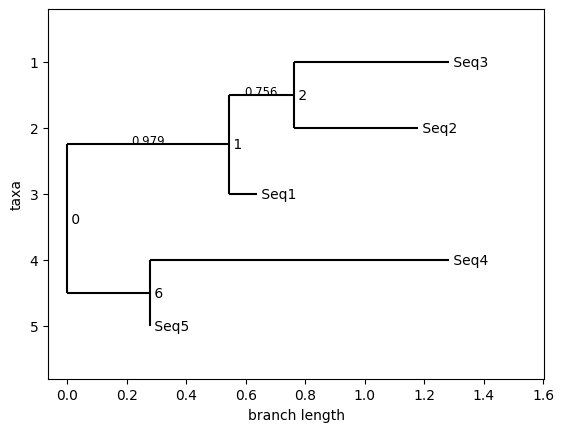

'(((((((..((((.........))))..((((.......))))......(((((.......)))))))))))).'

In [26]:
predict_structure(input_sequences, *_combined_params, *[0.19, 0.88, 1.48, 1.78, 0.98])